In [112]:
import csv
import pandas as pd
from typing import Any, List
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
from statsmodels.tsa.seasonal import seasonal_decompose

In [49]:
df = pd.read_csv("data/oura_hr.csv", header=0)
df['timestamp']=pd.to_datetime(df['timestamp']).dt.date
df.head(10)

,timestamp,bpm,quality,source,restorative
0,2021-11-29,88,good,awake,False
1,2021-11-29,98,good,awake,False
2,2021-11-29,94,good,awake,False
3,2021-11-29,108,average,awake,False
4,2021-11-29,120,average,awake,False
5,2021-11-29,124,average,awake,False
6,2021-11-29,94,good,awake,False
7,2021-11-29,90,good,awake,False
8,2021-11-29,95,good,awake,False
9,2021-11-29,89,good,awake,False


In [50]:
# aggregate daily numbers to: avg, mode, max, min
groupped_df = df.drop(['quality', 'source', 'restorative'], axis=1)

results_structure = {"day": [], "min":[], "max":[], "avg":[]}
def populate(input_dict: dict, input_array: Any, key: str):
    """ Helper iteration over dict and groupped DFs """
    for idx, value in input_array.items():
        if idx.isoformat() not in input_dict["day"]:
            input_dict["day"].append(idx.isoformat())
        if key == "avg":
            input_dict[key].append(int(value))
        else:
            input_dict[key].append(value)

lowest = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.min)
populate(results_structure, lowest, "min")
highest = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.max)
populate(results_structure, highest, "max")
avg = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.mean)
populate(results_structure, avg, "avg")
# mode = groupped_df.groupby(['timestamp'])['bpm'].agg(pd.Series.median())
# populate(results_structure, mode, "median")

bpm = pd.DataFrame.from_dict(results_structure)
bpm['day']=bpm['day'].astype(str)
bpm.head()

,day,min,max,avg
0,2021-11-29,61,124,85
1,2021-11-30,64,122,80
2,2021-12-01,64,147,82
3,2021-12-02,65,118,86
4,2021-12-03,37,127,83


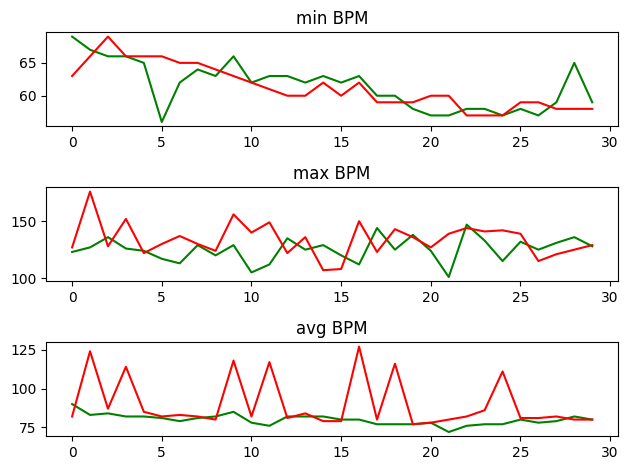

In [51]:
def plot_simple_period(df: pd.DataFrame, first_start: str, second_start: str, duration: int, plots: List[str]):
    """ Plot 3 metrics in separate figures for comparable time horizons """
    if first_start not in df['day'].tolist():
        raise Exception(f"No data was recorded for the start date: {first_start}")
    else:
        indx_start_1 = df.index[bpm['day'] == first_start].tolist()[0]
        indx_end_1 = indx_start_1 + duration

    if second_start not in df['day'].tolist():
        raise Exception(f"No data was recorded for this second start date: {second_start}")
    else:
        indx_start_2 = df.index[bpm['day'] == second_start].tolist()[0]
        indx_end_2 = indx_start_2 + duration
   
    x = [i for i in range(0, duration)]
    fig, axs = plt.subplots(len(plots))
        
    for idx, item in enumerate(plots):
        y1 = df[item][indx_start_1:indx_end_1]
        y2 = df[item][indx_start_2:indx_end_2]
        axs[idx].plot(x, y1, label=f'{item} BPM', color='green')
        axs[idx].plot(x, y2, color='red')
        axs[idx].set_title(f"{item} BPM")

    fig.tight_layout()
    
    
plot_simple_period(bpm, '2022-01-01', '2023-01-01', 30, ["min", "max", "avg"]) 


In [52]:
df = pd.read_csv("data/oura_sleep.csv", header=0)
df['day']=pd.to_datetime(df['day']).dt.date
df.head()



,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,time_in_bed,total_sleep_duration
0,19.500,68.09,37.0,4410.0,2021-11-30T09:01:08.000+01:00,2021-11-30T00:33:08.000+01:00,2021-11-30,5790.0,12210.0,8070.0,30480,26070.0
1,19.500,82.00,27.0,1200.0,2021-11-30T19:38:49.000+01:00,2021-11-30T19:17:49.000+01:00,2021-12-01,30.0,30.0,0.0,1260,60.0
2,18.375,66.44,42.0,6420.0,2021-12-01T07:20:18.000+01:00,2021-11-30T23:48:18.000+01:00,2021-12-01,5940.0,10230.0,4530.0,27120,20700.0
3,18.375,72.00,NaN,360.0,2021-12-01T12:19:47.000+01:00,2021-12-01T12:13:47.000+01:00,2021-12-01,0.0,0.0,0.0,360,0.0
4,18.375,76.33,45.0,1050.0,2021-12-01T18:46:03.000+01:00,2021-12-01T18:26:03.000+01:00,2021-12-02,0.0,150.0,0.0,1200,150.0


In [110]:
def plot_raw_timeseries(ts: pd.Series, start: str, end: str, duration: int):
    decomposition = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(10, 8))
    plt.subplot(4, 1, 1)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(4, 1, 2)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(4, 1, 4)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    
    plt.tight_layout()


df = df[['deep_sleep_duration', 'day']]
groupped = df.groupby('day').sum()
dfsleep = pd.DataFrame({
    'deep_sleep': groupped['deep_sleep_duration'],
})
dfsleep['deep_sleep'] = dfsleep['deep_sleep'].apply(lambda x: x / 60)
idx = pd.date_range(start=min(dfsleep.index), end=max(dfsleep.index), inclusive="both")
values = []
for i in idx.tolist():
#     print(f"{i.date()} vs {i.date() in dfsleep.index.tolist()}")
    if i.date() in dfsleep.index.tolist():
        values.append(dfsleep.loc[i.date()])
    else:
        values.append(np.nan)

        
        
sleep = pd.Series(values, index=idx)
sleep_filled = sleep.ffill()

/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/numpy/core/_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)
/home/alisa/projects/talks/conferences/EP_2023/.venv/ep-2023-e1-f7odT-py3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


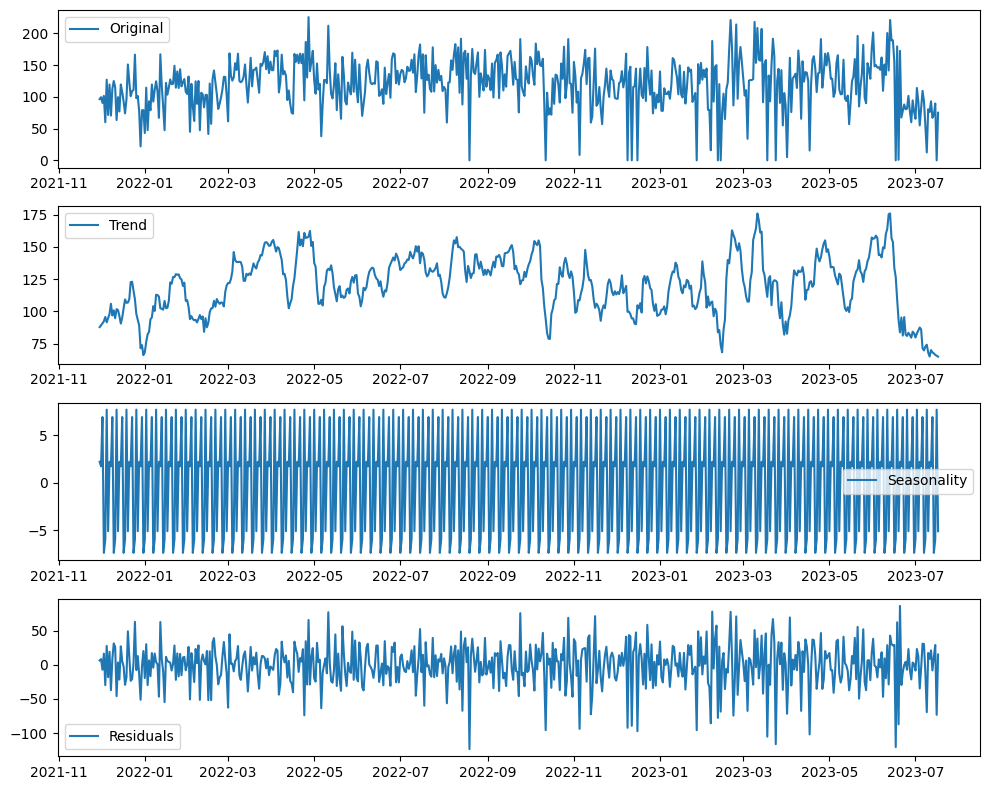

In [111]:
plot_raw_timeseries(sleep_filled, '2022-01-01', '2023-01-01', 90)

In [113]:
# other trend detection:
hpcycles = sm.tsa.filters.hpfilter(values, 1600 * 3 ** 4)
plt.plot(idx.tolist(), hpcycles[1].tolist(), label='smoothed trend', color='green')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (595,) + inhomogeneous part.